## Step 0. Folder Structure
```
3. Deep Learning Project/
├── dataset_split/
│   ├── train/
│   │   ├── african_elephant (780 images)
│   │   ├── airliner (780 images)
│   │   └── ... (8 more folders)
│   ├── val/
│   │   ├── african_elephant (260 images)
│   │   ├── airliner (260 images)
│   │   └── ... (8 more folders)
│   └── test (2600 images)
├── data_preprocessed/
│   ├── labels_train.pt
│   ├── labels_val.pt
│   ├── tensor_test.pt
│   ├── tensor_train.pt
│   └── tensor_val.pt
├── models/
│   ├── resnet18_checkpoint.pkl
│   └── resnet34_checkpoint.pkl
├── src/
│   └── part3.ipynb
├── src_datasplit/
│   └── data_split.ipynb
├── MSA.yaml
├── README.md
└── IEEE_Report_Template.docx
```


In [2]:
# TODO: Import the libraries.
from typing import Tuple, List
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import csv

## Step 1 Preprocessing
1. Load images and labels from folders into lists.
2. Resize the images.
3. Convert the image data type as float32 and limit the range in [0, 1].
4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.
5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).
6. Saving the pre-processed sets as .pt files in the correct directory.
7. Load the pre-processed sets from .pt files. 

In [3]:
# TODO: 1. Load images from folder into a list.
def image_loader(set_dir: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load all images from a dataset directory (train/val/test) into memory.
    Make sure:
        1. Load training and validation set images and labels in the correct order.
        2. Load testing set images in filename order (e.g., 0.jpg, 1.jpg, ...).
    
    Parameters:
    -----------
    set_dir : str
        Path to the directory containing either:
        - Class subdirectories (for train/val sets)
        - Direct image files (for test set)
        
    Returns:
    --------
    Tuple[List[np.ndarray], List[str]]
        images: List of BGR images (HWC format, uint8 dtype)
        labels: List of string labels (empty for test set)
    """
    
    images = []
    labels = []
    
    # Check if directory contains subdirectories (train/val) or direct images (test)
    is_test_set = not any(os.path.isdir(os.path.join(set_dir, x)) for x in os.listdir(set_dir))
    
    if is_test_set:
        # Test set: load images in filename order
        image_files = sorted(os.listdir(set_dir), key=lambda x: int(os.path.splitext(x)[0]))
        for file_name in tqdm(image_files, desc="Loading test images"):
            if file_name.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(set_dir, file_name)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as BGR
                if img is not None:
                    images.append(img)
                else:
                    print(f"Warning: Failed to load {img_path}")
        labels = []  # Empty labels for test set
    else:
        # Train/val set: load images and labels from class subdirectories
        class_dirs = sorted(os.listdir(set_dir))  # Sort for consistent order
        for class_name in tqdm(class_dirs, desc="Loading train/val images"):
            class_path = os.path.join(set_dir, class_name)
            if os.path.isdir(class_path):
                for file_name in sorted(os.listdir(class_path)):
                    if file_name.endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(class_path, file_name)
                        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load as BGR
                        if img is not None:
                            images.append(img)
                            labels.append(class_name)
                        else:
                            print(f"Warning: Failed to load {img_path}")
    
    return images, labels

In [4]:
# TODO: 2. Resize images.
def img_resize(images: List[np.ndarray], target_size: int = 224) -> np.ndarray:
    """
    Resize images with the shortest edge to target_size and perform center cropping to square dimensions.
    
    Args:
        images: List of input images in BGR format (OpenCV default) with shape (H, W, C)
        target_size: Desired output size (both width and height after cropping). Default 224.
        
    Returns:
        Stacked numpy array of processed images with shape (N, target_size, target_size, 3)
    """
    if not images:
        return np.array([])

    processed_images = []
    
    for img in images:
        if img is None or len(img.shape) != 3 or img.shape[2] != 3:
            raise ValueError("Invalid image: must be 3-channel BGR with shape (H, W, 3)")
        
        h, w = img.shape[:2]
        if h == 0 or w == 0:
            raise ValueError("Image has zero dimension")
        
        # Calculate scaling factor to make shortest edge >= target_size
        scale = target_size / min(h, w)
        new_h, new_w = int(h * scale), int(w * scale)
        
        # Resize image
        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Ensure resized image is large enough for cropping
        if new_h < target_size or new_w < target_size:
            # Pad image if necessary
            pad_h = max(target_size - new_h, 0)
            pad_w = max(target_size - new_w, 0)
            top, bottom = pad_h // 2, pad_h - (pad_h // 2)
            left, right = pad_w // 2, pad_w - (pad_w // 2)
            resized_img = cv2.copyMakeBorder(
                resized_img, top, bottom, left, right, 
                cv2.BORDER_CONSTANT, value=[0, 0, 0]
            )
            new_h, new_w = resized_img.shape[:2]
        
        # Center crop to target_size x target_size
        start_h = (new_h - target_size) // 2
        start_w = (new_w - target_size) // 2
        cropped_img = resized_img[start_h:start_h + target_size, start_w:start_w + target_size]
        
        # Verify cropped image shape
        if cropped_img.shape != (target_size, target_size, 3):
            raise ValueError(f"Cropped image has incorrect shape: {cropped_img.shape}")
        
        processed_images.append(cropped_img)
    
    return np.stack(processed_images)

In [5]:
# Load images

images_train, labels_train = image_loader("../dataset_split/train")
images_val, labels_val = image_loader("../dataset_split/val")
images_test, _ = image_loader("../dataset_split/test")

Loading test images: 100%|████████████████████████████████████████████████████████| 2600/2600 [00:16<00:00, 162.26it/s]


In [ ]:
# Resize the images

images_train = img_resize(images_train, 224)
images_val = img_resize(images_val, 224)
images_test = img_resize(images_test, 224)

In [ ]:
# TODO: 3. Convert the image data type as float32 and limit the range in [0, 1].

images_train = images_train.astype(np.float32) / 255.0
images_val = images_val.astype(np.float32) / 255.0
images_test = images_test.astype(np.float32) / 255.0

In [ ]:
# TODO: 4. Convert data from NHWC to NCHW and creat a PyTorch tensor from it.

tensor_train = torch.from_numpy(images_train.transpose(0, 3, 1, 2))
tensor_val = torch.from_numpy(images_val.transpose(0, 3, 1, 2))
tensor_test = torch.from_numpy(images_test.transpose(0, 3, 1, 2))

In [ ]:
# TODO: 5. Per-channel standardization of the dataset using training set statistics (mean and std computed independently for each color channel).

# Compute per-channel mean and std from training set
train_mean = tensor_train.mean(dim=(0, 2, 3))  # Shape: (3,)
train_std = tensor_train.std(dim=(0, 2, 3))    # Shape: (3,)

# Standardize datasets: (x - mean) / std
tensor_train = (tensor_train - train_mean.view(1, 3, 1, 1)) / train_std.view(1, 3, 1, 1)
tensor_val = (tensor_val - train_mean.view(1, 3, 1, 1)) / train_std.view(1, 3, 1, 1)
tensor_test = (tensor_test - train_mean.view(1, 3, 1, 1)) / train_std.view(1, 3, 1, 1)

In [ ]:
# TODO: 6. Save the pre-processed sets as .pt files.
# 6.1 Save tensor_train, tensor_val, and tensor_test as .pt files
torch.save(tensor_train, "../data_preprocessed/tensor_train.pt")
torch.save(tensor_val, "../data_preprocessed/tensor_val.pt")
torch.save(tensor_test, "../data_preprocessed/tensor_test.pt")

# 6.2 Create unique_labels list and label_to_index dictionary
unique_labels = sorted(set(labels_train))  # ['african_elephant', 'airliner', ...]
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# 6.3 Map labels to indices
labels_train_index = np.array([label_to_index[label] for label in labels_train])
labels_val_index = np.array([label_to_index[label] for label in labels_val])

# 6.4 Save labels_train_index, labels_val_index, and label mappings
torch.save(torch.tensor(labels_train_index), "../data_preprocessed/labels_train.pt")
torch.save(torch.tensor(labels_val_index), "../data_preprocessed/labels_val.pt")
torch.save(unique_labels, "../data_preprocessed/unique_labels.pt")
torch.save(label_to_index, "../data_preprocessed/label_to_index.pt")


In [ ]:
# TODO: 7. Load the pre-processed sets from .pt files. The data can be used directly in future without pre-processing once more by loading from the folder.

tensor_train = torch.load('../data_preprocessed/tensor_train.pt')
tensor_val = torch.load('../data_preprocessed/tensor_val.pt')
tensor_test = torch.load('../data_preprocessed/tensor_test.pt')

labels_train_index = torch.load('../data_preprocessed/labels_train.pt')
labels_val_index = torch.load('../data_preprocessed/labels_val.pt')

# Step 2 Train the teacher model (ResNet34)
1. Set hyperparameters for the training process.
2. Create a pretrained ResNet34.
3. Define the optimizer, loss function, etc.
4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
5. Plot the loss and accuracy curves.

In [17]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [22]:
# TODO: 1. Set hyperparameters for the training process.

# Set hyperparameters for the training process
MAX_EPOCH = 5
INIT_LR = 0.0001
BATCH_SIZE = 32

# Specify the training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# TODO: 2. Create a pretrained ResNet34.
import torchvision.models as models
import torch.nn as nn

# 2.1 Use torchvision to create a pretrained ResNet34
resnet34 = models.resnet34(weights='IMAGENET1K_V1')

# 2.2 Modify the output layer to align with project (10 classes)
num_classes = 10
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)

# 2.3 Move the model to selected device
resnet34 = resnet34.to(device)


In [24]:
# TODO: 3. Define the optimizer, loss function, etc.

optimizer = torch.optim.Adam(resnet34.parameters(), lr=INIT_LR)
criterion = nn.CrossEntropyLoss()

In [25]:
# TODO: 4. Train ResNet34 and save the best-performing parameters to 'resnet34_checkpoint.pkl'.
# Hint: May not need too many epochs as this is a pretrained model.

from torch.utils.data import DataLoader, TensorDataset

# Create DataLoaders
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, max_epoch, device, save_path):
    best_val_acc = 0.0
    best_model_state = None
    patience = 5  # Early stopping patience
    patience_counter = 0
    
    train_accs, train_losses, val_accs, val_losses = [], [], [], []
    
    for epoch in range(max_epoch):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Save best model parameters
    torch.save(best_model_state, save_path)
    return train_accs, train_losses, val_accs, val_losses

# Train ResNet34
train_accs_resnet34, train_losses_resnet34, val_accs_resnet34, val_losses_resnet34 = train_model(
    resnet34, train_loader, val_loader, criterion, optimizer, MAX_EPOCH, device, 
    '../models/resnet34_checkpoint.pkl'
)


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [13:32<00:00,  3.33s/it]


Epoch 1: Train Loss: 0.2033, Train Acc: 0.9442, Val Loss: 0.1253, Val Acc: 0.9615


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [13:36<00:00,  3.35s/it]


Epoch 2: Train Loss: 0.0465, Train Acc: 0.9863, Val Loss: 0.1090, Val Acc: 0.9696


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [13:39<00:00,  3.36s/it]


Epoch 3: Train Loss: 0.0334, Train Acc: 0.9900, Val Loss: 0.1259, Val Acc: 0.9642


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [13:39<00:00,  3.36s/it]


Epoch 4: Train Loss: 0.0249, Train Acc: 0.9933, Val Loss: 0.1178, Val Acc: 0.9658


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [13:35<00:00,  3.34s/it]


Epoch 5: Train Loss: 0.0280, Train Acc: 0.9922, Val Loss: 0.0957, Val Acc: 0.9685


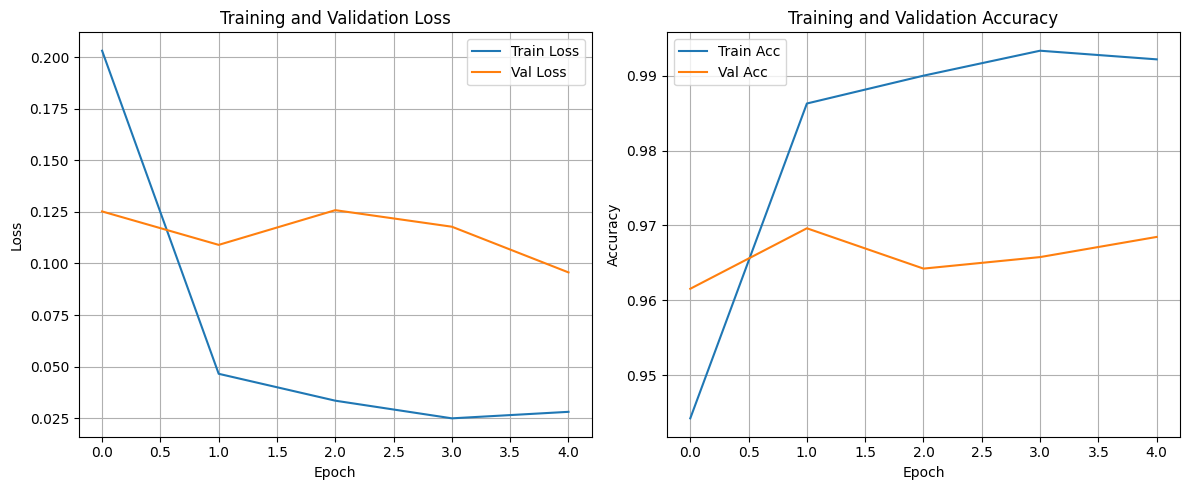

In [26]:
# TODO: 5. Plot the loss and accuracy curves.
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet34, label='Train Loss')
plt.plot(val_losses_resnet34, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet34, label='Train Acc')
plt.plot(val_accs_resnet34, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Step 3 Train the student model (ResNet18)
1. Set hyperparameters for the distillation process.
2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
3. Load the saved ResNet34 and move the model to selected device.
4. Define the optimizer, loss function, etc.
5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
6. Plot the loss and accuracy curves.

In [27]:
# Verify data shapes

num_classes = max(labels_train_index) + 1
print(num_classes)
print(tensor_train.shape)
print(tensor_val.shape)
print(tensor_test.shape)
print(labels_train_index.shape)
print(labels_val_index.shape)

tensor(10)
torch.Size([7800, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([2600, 3, 224, 224])
torch.Size([7800])
torch.Size([2600])


In [33]:
# TODO: 1. Set hyperparameters for the distillation process.

MAX_EPOCH = 5
INIT_LR = 0.0001
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TEMPERATURE = 4.0
LOSS_RATIO = 0.5

In [34]:
# TODO: 2. Create a NON-PRETRAINED ResNet18 and move the model to selected device.
import torchvision.models
import torch.nn as nn

# Create a non-pretrained ResNet18 and move to device
resnet18 = torchvision.models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)

In [35]:
# TODO: 3. Load the saved ResNet34 and move the model to selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

# Load saved ResNet34, move to device, and set to evaluation mode
resnet34 = torchvision.models.resnet34(weights=None)
resnet34.fc = nn.Linear(resnet34.fc.in_features, num_classes)
resnet34.load_state_dict(torch.load('../models/resnet34_checkpoint.pkl'))
resnet34 = resnet34.to(device)
resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
# TODO: 4. Define the optimizer, loss function, etc.

# Define optimizer and scheduler
optimizer = torch.optim.Adam(resnet18.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [37]:
# TODO: 5. Train ResNet18 and save the best-performing parameters to 'resnet18_checkpoint.pkl'.
# Hint: Use the correct loss function for knowledge distillation.
#       Details can be fund in https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html.

from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import kl_div, log_softmax, softmax

# Create DataLoaders
train_dataset = TensorDataset(tensor_train, labels_train_index)
val_dataset = TensorDataset(tensor_val, labels_val_index)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Knowledge distillation loss function
def distillation_loss(student_logits, teacher_logits, labels, temperature, loss_ratio):
    # Hard loss (CrossEntropy with true labels)
    hard_loss = nn.CrossEntropyLoss()(student_logits, labels)
    
    # Soft loss (KL Divergence with teacher soft targets)
    soft_loss = nn.KLDivLoss(reduction='batchmean')(
        log_softmax(student_logits / temperature, dim=1),
        softmax(teacher_logits / temperature, dim=1)
    ) * (temperature ** 2)
    
    # Combined loss
    return loss_ratio * soft_loss + (1 - loss_ratio) * hard_loss

# Training function
def train_distillation(student, teacher, train_loader, val_loader, optimizer, scheduler, max_epoch, device, temperature, loss_ratio, save_path):
    best_val_acc = 0.0
    best_model_state = None
    patience = 5  # Early stopping patience
    patience_counter = 0
    
    train_accs, train_losses, val_accs, val_losses = [], [], [], []
    
    for epoch in range(max_epoch):
        # Training phase
        student.train()
        teacher.eval()  # Teacher in eval mode
        train_loss, train_correct, train_total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            with torch.no_grad():
                teacher_logits = teacher(inputs)
            student_logits = student(inputs)
            
            # Compute distillation loss
            loss = distillation_loss(student_logits, teacher_logits, labels, temperature, loss_ratio)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(student_logits, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        
        # Validation phase
        student.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                teacher_logits = teacher(inputs)
                student_logits = student(inputs)
                
                loss = distillation_loss(student_logits, teacher_logits, labels, temperature, loss_ratio)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(student_logits, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(student.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Save best model parameters
    os.makedirs('../models', exist_ok=True)
    torch.save(best_model_state, save_path)
    return train_accs, train_losses, val_accs, val_losses

# Train ResNet18 with knowledge distillation
train_accs_resnet18, train_losses_resnet18, val_accs_resnet18, val_losses_resnet18 = train_distillation(
    resnet18, resnet34, train_loader, val_loader, optimizer, scheduler, 
    MAX_EPOCH, device, TEMPERATURE, LOSS_RATIO, '../models/resnet18_checkpoint.pkl'
)


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [11:24<00:00,  2.81s/it]


Epoch 1: Train Loss: 3.9433, Train Acc: 0.5501, Val Loss: 2.7140, Val Acc: 0.6912


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [11:21<00:00,  2.79s/it]


Epoch 2: Train Loss: 2.7656, Train Acc: 0.7000, Val Loss: 2.3803, Val Acc: 0.7362


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [11:27<00:00,  2.82s/it]


Epoch 3: Train Loss: 2.2925, Train Acc: 0.7619, Val Loss: 2.0839, Val Acc: 0.7565


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [11:23<00:00,  2.80s/it]


Epoch 4: Train Loss: 1.9007, Train Acc: 0.8085, Val Loss: 2.2527, Val Acc: 0.7388


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 244/244 [11:22<00:00,  2.80s/it]


Epoch 5: Train Loss: 1.5790, Train Acc: 0.8496, Val Loss: 2.3924, Val Acc: 0.7250


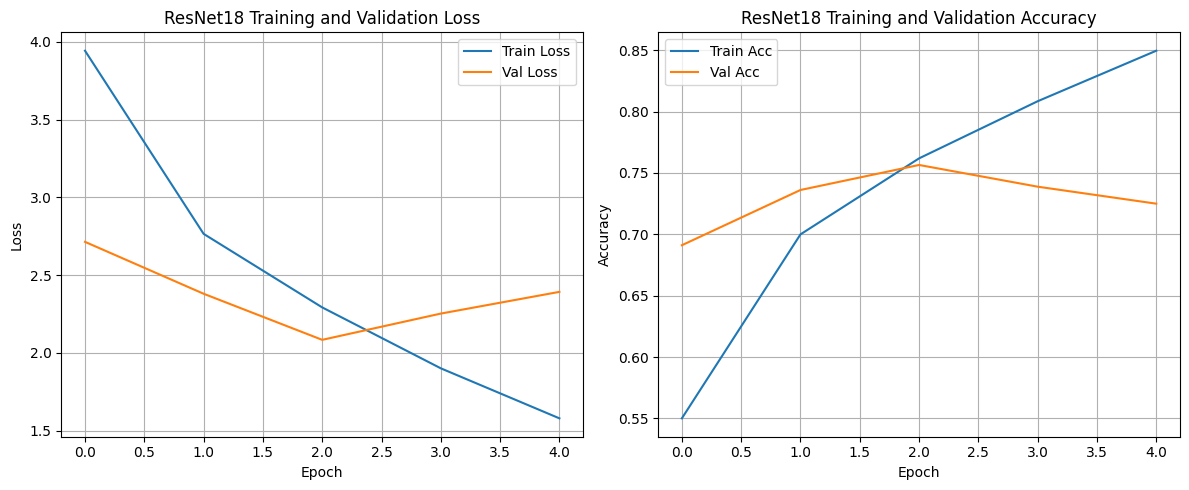

In [38]:
# TODO: 6. Plot the loss and accuracy curves.

# Plot loss and accuracy curves for ResNet18
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_resnet18, label='Train Loss')
plt.plot(val_losses_resnet18, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs_resnet18, label='Train Acc')
plt.plot(val_accs_resnet18, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 4 Predict labels in the testing set
1. Load the saved ResNet18 and move it to the selected device.
2. Do prediction using the images in the testing set.
3. Write the results into the CSV file for submission.

In [39]:
# TODO: 1. Load the saved ResNet18 and move it to the selected device.
# Hint: Enable the evaluation mode to prevent updating the parameters.

resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18.load_state_dict(torch.load('../models/resnet18_checkpoint.pkl'))
resnet18 = resnet18.to(device)
resnet18.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
# TODO: 2. Do prediction using the images in the testing set.
# Predict labels for the testing set
predictions = []

# Create DataLoader for test set
test_dataset = TensorDataset(tensor_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Inference
resnet18.eval()
with torch.no_grad():
    for inputs, in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())


Predicting: 100%|██████████████████████████████████████████████████████████████████████| 82/82 [00:51<00:00,  1.58it/s]


In [41]:
# TODO: 3. Write the results into the CSV file for submission.
# Hint: The CSV file should be in the format of 'file_name' and 'label'.
#       The submission.csv should look like:
#           file_name,label
#           0.jpg,sunglasses
#           ...

# Load index-to-label mapping
label_to_index = torch.load('../data_preprocessed/label_to_index.pt')
index_to_label = {v: k for k, v in label_to_index.items()}

# Create submission CSV
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['file_name', 'label'])  # Write header
    for i, pred_idx in enumerate(predictions):
        file_name = f"{i}.jpg"
        label = index_to_label[pred_idx]
        writer.writerow([file_name, label])
